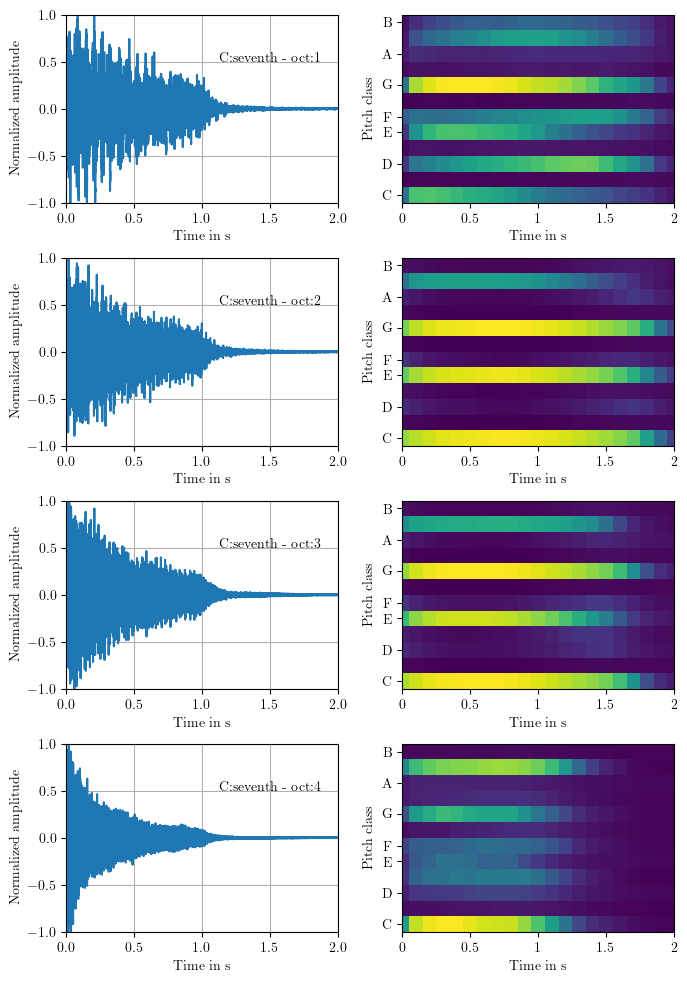

In [1]:
import dataloader
import utils
from matplotlib import pyplot as plt

root = 'C'
chordtype = "seventh"
octave = [1,2,3,4]
loader = dataloader.BeatlesDataset(None,chroma_type='librosa',beat_align=False)

n = len(octave)
fig,ax = plt.subplots(n,2,figsize=(7,n*2.5))
fig.tight_layout(pad=2)
for i,x in enumerate(octave):
    path = f"/home/max/ET-TI/Masterarbeit/datasets/jazznet/chords/{chordtype}/{root}-{x}-{chordtype}-chord-3.wav"
    t,chroma = loader.getChroma(path,'madmom')
    utils.plotAudioWaveform(ax[i,0],path,(0,2))
    ax[i,0].text(1.5,0.5,f"{root}:{chordtype} - oct:{x}",horizontalalignment='center')
    utils.plotChroma(ax[i,1],chroma,(0,2))


modifizierte Kullback-Leibler Divergenz </br>
$D_{mKL}=\sum_{k=0}^{K-1}ln\big(1+ \frac{|X[k,n]|}{|X[k,n-1]|+\epsilon}\big)$ </br>
Sie ist in maß für die Unterschiede zwischen zwei Wahrscheinlichkeitsverteilungen. </br>
Änderungen im Chromavektor könnten mit dieser Funktion dedektiert werden. </br>
Als alternative wird ein beat-gemitteltes chroma gerechnet


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import circularPitchSpace as cps
import dataloader

dataset_madmom = dataloader.BeatlesDataset("/home/max/ET-TI/Masterarbeit/datasets/beatles",beat_align=False)
dataset_librosa = dataloader.BeatlesDataset("/home/max/ET-TI/Masterarbeit/datasets/beatles",'librosa')

def movingAverage(data,N=5):
    mean = np.zeros_like(data)
    i = N
    mean[:i] = np.sum(data[:i]/i)
    while i < data.shape[0]:
        # Calculate the average of current window
        mean[i] = np.sum(data[i-N:i])/N
        i += 1
    return mean

def modifiedKullbackLeiblerDivergence(chroma,remove_mean=True,normalize=True):
    if chroma.shape[0] < 2 or chroma.shape[1] != 12:
        raise ValueError("invalid chroma vector")
    X_0 = chroma
    X_1 = np.zeros_like(X_0)
    # shift array by one sample in horizontal 
    X_1[1:,:] = X_0[:-1,:]
    # calculate modified kullback-leibler-divergence
    dkl = np.sum(np.log(1+np.abs(X_0)/(np.abs(X_1)+np.finfo(float).eps)),axis=1)
    # ignore first sample
    dkl[0] = 0.0
    if remove_mean:
        dkl = dkl - movingAverage(dkl,15)
        dkl[dkl<0] = 0.0   
    if normalize:
        dkl = dkl/np.max(dkl)
    return dkl

t_chroma,chroma,ref_intervals,ref_labels = dataset_madmom[103]


In [5]:
%matplotlib inline
from ipywidgets import interact, FloatSlider,BoundedIntText
from IPython.display import display

def adjust_axes(x,y):
    ax.set_xlim(x,y)
    display(fig)

fig,ax = plt.subplots(figsize=(12,5))
fig.tight_layout(pad=2.0)
utils.plotChroma(ax,chroma,time=None)
dkl = 10 * modifiedKullbackLeiblerDivergence(chroma,remove_mean=True,normalize=True)
ax.plot(np.linspace(0,(chroma.shape[0]-1)*4410/44100,chroma.shape[0]),dkl,'r',linewidth=1)
ax.set_ylim((-0.5,11.5))
plt.close()

interact(adjust_axes,
         x = BoundedIntText(value=0,min=0,max=int(chroma.shape[0]/10),step=1,description='xlim:',disabled=False),
         y = BoundedIntText(value=10,min=0,max=int(chroma.shape[0]/10),step=1,description='ylim:',disabled=False)
)

interactive(children=(BoundedIntText(value=0, description='xlim:', max=243), BoundedIntText(value=10, descript…

<function __main__.adjust_axes(x, y)>